<div style="text-align: center;">
  <h1>Western Governors University (WGU)</h1>  
  <h1>Advanced Data Analytics — D213</h1>  
  <h1>Task 1: Time Series Modeling</h1>  
  <h1>Natallia Zimnitskaya | ID: 012247127</h1>  
  <h1>Master of Science, Data Analytics</h1>
</div>



**A1:RESEARCH QUESTION**

Can the ARIMA model accurately predict the revenue for the WGU Hospital System over the next 90 days based on the daily revenue data from the previous two years of operation?

Given the financial penalties for patient readmissions imposed by the Centers for Medicare and Medicaid Services (CMS), this question is crucial. By employing the ARIMA model, the analysis aims to uncover patterns and trends in the revenue data, providing reliable short-term forecasts. These insights will help hospital executives make informed financial decisions and strategize effectively to mitigate the impact of readmission penalties, ensuring financial stability and growth.

**A2:OBJECTIVES OR GOALS** 
                                                                                                                      
The objectives and goals for this analysis are to identify patterns and trends by analyzing the daily revenue data to detect any underlying patterns, trends, and seasonality. Additionally, the analysis aims to generate reliable forecasts using the identified patterns to create a revenue forecast for the next 90 days, providing hospital executives with a clear picture of expected financial performance. 
Another key objective is to assess the financial impact by evaluating the potential effect of readmission penalties on future revenue, given the hospital's historical trends and current strategies. 
The analysis also seeks to inform decision-making by enabling hospital executives to make informed financial decisions and develop strategies to minimize readmission penalties and optimize revenue generation. 
Ultimately, the goal is to enhance financial stability by providing actionable insights based on revenue forecasts, ensuring the hospital's financial stability and growth.


**B:SUMMARY OF ASSUMPTIONS** 
    
Time series models rely on some key assumptions to make accurate predictions. Two of the most important ones are stationarity and autocorrelation.
    
Stationarity means that the statistical properties of the data, like its average and variance, stay consistent over time. This is important because many models, including ARIMA, work best when the data is stable. Sometimes, transformations like differencing are applied to the data to achieve stationarity.

Conversely, autocorrelation refers to the correlation between the data points and their past values. This is crucial for identifying relationships within the data and helps the model capture patterns to predict future values. The model can make more accurate and reliable forecasts by ensuring the data meets these assumptions.

    



To begin the data cleaning process, I ensured the dataset was free of missing or duplicate values. The dataset consists of 731 entries with daily revenue data for the 2023-2024 period of the WGU Hospital System's operation, making it crucial to maintain data integrity for accurate analysis. To create this assessment, an adaptation of code provided by Dr. Elleh in his D213 PowerPoint presentation was used (Elleh, n.d.).


In [1]:
#import packages and libraries
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from scipy.signal import periodogram
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA

import warnings
warnings.filterwarnings('ignore')

# The CSV's first column is an index and Pandas will duplicate this and create an column without 'index_col=0'
df = pd.read_csv('medical_time_series.csv')
# Check data types and number of values, as well as overall size of dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Day      731 non-null    int64  
 1   Revenue  731 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 11.6 KB


In [2]:
print("df shape: ",df.shape)
df.head()

df shape:  (731, 2)


,Day,Revenue
0,1,0.000000
1,2,-0.292356
2,3,-0.327772
3,4,-0.339987
4,5,-0.124888


In [3]:
#check null values
df.isnull().any()


Day        False
Revenue    False
dtype: bool

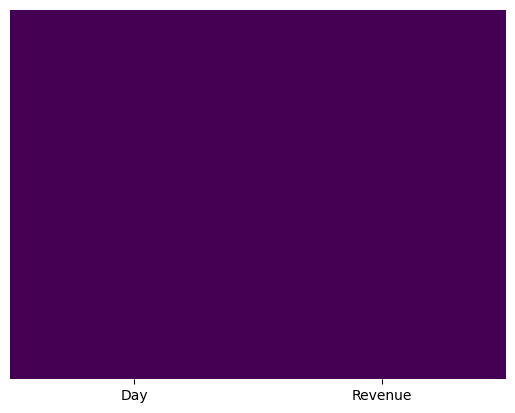

In [4]:
#visualize if there are null values
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis');

In [5]:
df.dropna()

,Day,Revenue
0,1,0.000000
1,2,-0.292356
2,3,-0.327772
3,4,-0.339987
4,5,-0.124888
...,...,...
726,727,15.722056
727,728,15.865822
728,729,15.708988
729,730,15.822867


In [6]:
#check for duplicates
df.duplicated().sum()

0

In [7]:
#get data statistiocs
df.describe()

,Day,Revenue
count,731.000000,731.000000
mean,366.000000,14.179608
std,211.165812,6.959905
min,1.000000,-4.423299
25%,183.500000,11.121742
50%,366.000000,15.951830
75%,548.500000,19.293506
max,731.000000,24.792249


In [8]:
#get df columns
df.columns

Index(['Day', 'Revenue'], dtype='object')

**C2:TIME STEP FORMATTING**

In [9]:
#set the starting date to January 1, 2023
start_date = pd.to_datetime('2023-01-01')

#convert the 'Day' column to a timedelta (difference in days) and add the start date to each entry
#subtract 1 from 'Day' to count from 0 instead of 1
df['Day'] = pd.to_timedelta(df['Day']-1, unit='D') + start_date

#rename the 'Day' column to 'Date'
df.rename(columns={'Day': 'Date'}, inplace=True)

#set the 'Date' column as the index of the DataFrame
df.set_index('Date', inplace=True)

#display the df to check if everything looks correct
df

,Revenue
Date,
2023-01-01,0.000000
2023-01-02,-0.292356
2023-01-03,-0.327772
2023-01-04,-0.339987
2023-01-05,-0.124888
...,...
2024-12-27,15.722056
2024-12-28,15.865822
2024-12-29,15.708988


In [10]:
#check for gaps in the 'Date' index
missing_dates = df.index.to_series().diff().dt.days - 1
gaps = missing_dates[missing_dates > 0]
print('Gaps in measurement:', gaps)

Gaps in measurement: Series([], Name: Date, dtype: float64)


Since the time series data didn't have a specific starting date, I chose January 1, 2023, as the starting point. The dataset consists of daily revenue observations over two years, spanning from January 1, 2023, to December 31, 2024. I converted the 'Day' column to a datetime format starting from January 1, 2023, and set it as the index of the DataFrame. The data is continuous, with no gaps in measurement, providing a complete sequence of 731 days.

**C1:LINE GRAPH VISUALIZATION** 

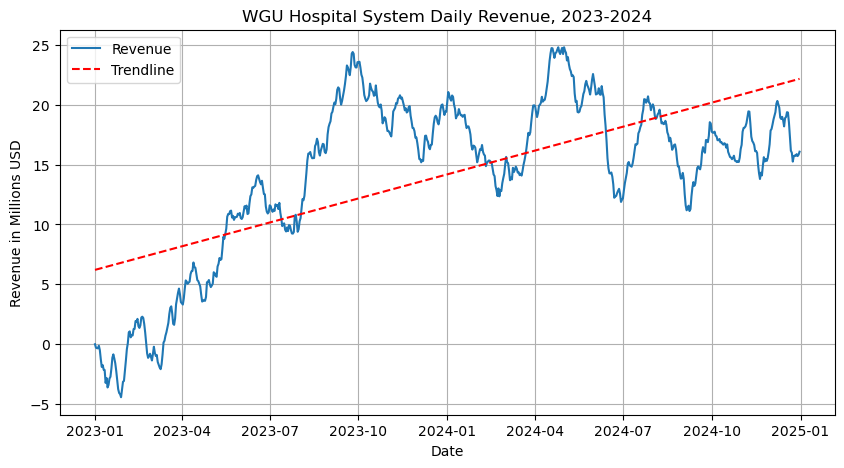

In [11]:
#create a line graph visualizing the realization of the time series
plt.figure(figsize=(10,5))
plt.plot(df['Revenue'], label='Revenue')
plt.title('WGU Hospital System Daily Revenue, 2023-2024')
plt.xlabel('Date')
plt.ylabel('Revenue in Millions USD')
plt.grid(True)

#generate trend line
x = mdates.date2num(df.index)
y = df['Revenue']
z = np.polyfit(x, y, 1)
p = np.poly1d(z)

plt.plot(df.index, p(x), "r--", label='Trendline')
plt.legend()
plt.show()


The graph **“WGU Hospital System Daily Revenue, 2023-2024”** shows the daily revenue trends of the hospital over two years. 
The red dashed trendline indicates an overall upward trend in revenue during this period, despite the significant fluctuations observed in the daily revenue data represented by the blue line. These fluctuations suggest variability in revenue due to factors such as seasonal variations or patient admissions. 
There are notable peaks indicating periods of high income, which could correspond to specific events or increased patient admissions, and troughs that might result from lower admissions, holidays, or other operational challenges. The pattern suggests possible seasonal effects, with some peaks and troughs potentially aligning with particular times of the year, such as flu season or holiday periods. 
By analyzing this graph, hospital executives can gain insights into both the short-term variability and long-term growth trends in revenue, helping them make informed decisions to optimize financial performance and address any operational challenges affecting daily revenue.

**C3:STATIONARITY**

In [12]:
#verify if data is stationary
result = adfuller(df['Revenue'])
print("Test Statistics: ", result[0])
print("p-value: ", result[1])
print("Critical Values: ",result[4])
#accept or reject null hypothesis and compare result against threshold
if result[1] <= 0.05:  
    print("Reject null hypothesis, this time series data is stationary.")
else:
    print("Accept null hypothesis, this time series data is non-stationary!")


Test Statistics:  -2.2183190476089454
p-value:  0.19966400615064356
Critical Values:  {'1%': -3.4393520240470554, '5%': -2.8655128165959236, '10%': -2.5688855736949163}
Accept null hypothesis, this time series data is non-stationary!


I first used the Dickey-Fuller test to evaluate the stationarity of the time series. 

The initial results showed a test statistic of -2.2183 and a p-value of 0.1997, with critical values of -3.4394, -2.8655, and -2.5689 at the 1%, 5%, and 10% levels. Since the test statistic was higher than the critical values and the p-value was greater than 0.05, I accepted the null hypothesis, indicating that the data was non-stationary.

Next, I performed first-order differencing on the ‘Revenue’ column of the dataset to make the data stationary. 


In [13]:
#conduct first-order differencing
df_stat = df.Revenue - df.Revenue.shift(1)
df_stat = df_stat.dropna(inplace=False)
print(df_stat)

Date
2023-01-02   -0.292356
2023-01-03   -0.035416
2023-01-04   -0.012215
2023-01-05    0.215100
2023-01-06   -0.366702
                ...   
2024-12-27   -0.032693
2024-12-28    0.143766
2024-12-29   -0.156834
2024-12-30    0.113880
2024-12-31    0.246562
Name: Revenue, Length: 730, dtype: float64


In [14]:
#test if data is stationary again
result = adfuller(df_stat)
print("Test Statistics: ", result[0])
print("p-value: ", result[1])
print("Critical Values: ",result[4])

#accept or reject null hypothesis and compare result against threshold
if result[1] <= 0.05:  
    print("Reject null hypothesis, this time series data is stationary.")
else:
    print("Accept null hypothesis, this time series data is non-stationary!")


Test Statistics:  -17.374772303557062
p-value:  5.113206978840171e-30
Critical Values:  {'1%': -3.4393520240470554, '5%': -2.8655128165959236, '10%': -2.5688855736949163}
Reject null hypothesis, this time series data is stationary.


After differencing, I ran the Dickey-Fuller test again.

This time, the results showed a test statistic of -17.3748 and a p-value of 5.1132e-30, with critical values remaining the same. These results allowed me to reject the null hypothesis, indicating that the differenced time series data was now stationary.
Finally, I plotted the differenced data to verify its stationarity visually. This process ensured that the data was appropriately prepared for accurate time series analysis and forecasting.


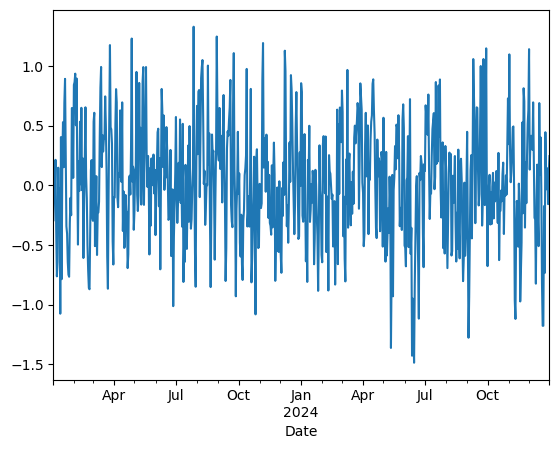

In [15]:
#plot to verify stationarity
df_stat.plot();

**C4:STEPS TO PREPARE THE DATA**

To prepare the data for analysis, I followed these steps in Jupyter Notebook:

•	Importing packages and libraries

•	Loading the data from the CSV file into a DataFrame for analysis.

•	Inspecting the data for missing and duplicate values to ensure data integrity and completeness.

•	Exploring data statistics and reviewing data statistics, including mean, median, standard deviation, and other relevant metrics, to understand the data distribution and variability.

•	Converting the 'Day' column to a datetime format starting from January 1, 2023, and setting it as the index. This step ensures proper time step formatting for time series analysis.

•	Plotting the time series to visualize the daily revenue data and identify trends, seasonality, or anomalies.

•	Evaluating stationarity, conducting the Augmented Dickey-Fuller (ADF) test to evaluate the stationarity of the time series, and applying first-order differencing to achieve stationarity are crucial for reliable time series modeling.

•	Splitting the data into training (80%) and test (20%) sets to evaluate the model's performance on unseen data.


**C5:PREPARED DATA SET** Please see the ‘D213_task1_cleaned_df.csv’ file attached to the submission.

In [16]:
#export cleaned data to csv file
pd.DataFrame(df).to_csv("D213_task1_cleaned_df.csv")

In [17]:
#get the shape of the train and test datasets
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

print('Train dataset shape:', train.shape)
print('Test dataset shape:', test.shape)
#export cleaned data to csv file
pd.DataFrame(df).to_csv("D213_task1_cleaned_df.csv")

Train dataset shape: (584, 1)
Test dataset shape: (147, 1)


In [18]:
#save train and test datasets to csv 
train.to_csv('D213_task1_train.csv')

test.to_csv('D213_task1_test.csv')

**D1:REPORT FINDINGS AND VISUALIZATIONS**

**•	Seasonal component**

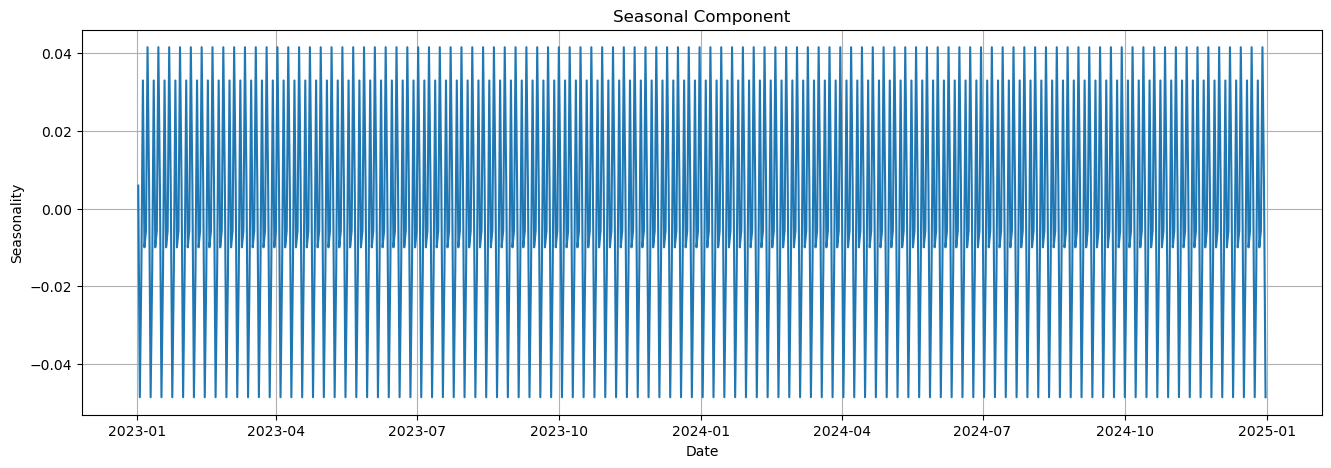

In [19]:
#decompose the stationary data
decomposed_data = seasonal_decompose(df_stat, model='additive')

#plot the seasonal component
plt.figure(figsize=[16,5])
plt.plot(decomposed_data.seasonal)
plt.title('Seasonal Component')
plt.xlabel('Date')
plt.ylabel('Seasonality')
plt.grid(True)
plt.show()

The seasonal component plot reveals a clear monthly seasonality pattern. This is evident from the regular, repeating peaks and troughs that occur approximately every month. The values oscillate between -0.04 and 0.04, indicating cyclical behavior consistent with monthly changes. This suggests that the data exhibits predictable fluctuations that repeat each month, typical for many time series datasets like sales, temperature, or other periodic phenomena. 

Recognizing this monthly seasonality is crucial for accurate forecasting and planning, as it highlights the dataset's consistent and predictable patterns.

I decided to visualize monthly seasonality by highlighting the start of each month with red lines, making it easier to identify repeating patterns and trends over the year 2023.


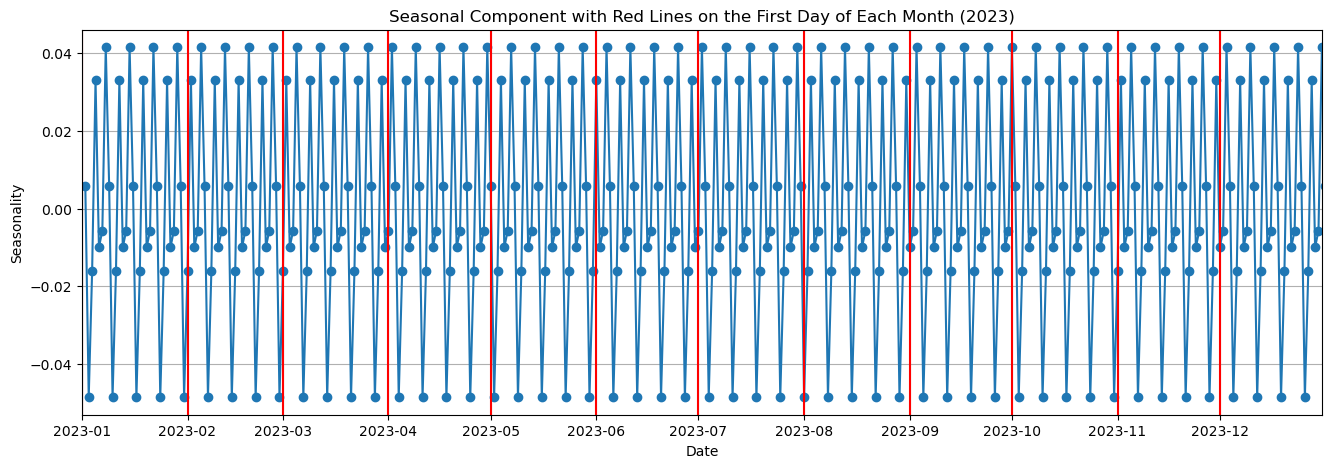

In [20]:
plt.figure(figsize=[16, 5])

#plot the seasonal component of the data
plt.plot(decomposed_data.seasonal, marker='o')
plt.xlim(pd.to_datetime('2023-01-01'), pd.to_datetime('2023-12-31'))

#draw red lines on the first day of each month in 2023
monthly_dates = [
    '2023-01-01', '2023-02-01', '2023-03-01', '2023-04-01', 
    '2023-05-01', '2023-06-01', '2023-07-01', '2023-08-01', 
    '2023-09-01', '2023-10-01', '2023-11-01', '2023-12-01'
]
for date in monthly_dates:
    plt.axvline(x=pd.to_datetime(date), color='red')

plt.title('Seasonal Component with Red Lines on the First Day of Each Month (2023)')
plt.xlabel('Date')
plt.ylabel('Seasonality')
plt.grid(True)
plt.show()

The seasonal component plot for the year 2023 indicates a clear monthly seasonality in the data. This pattern is highlighted by the recurring peaks and troughs that appear at regular intervals, corresponding to the beginning of each month, as marked by the red vertical lines.



**•	Trends**

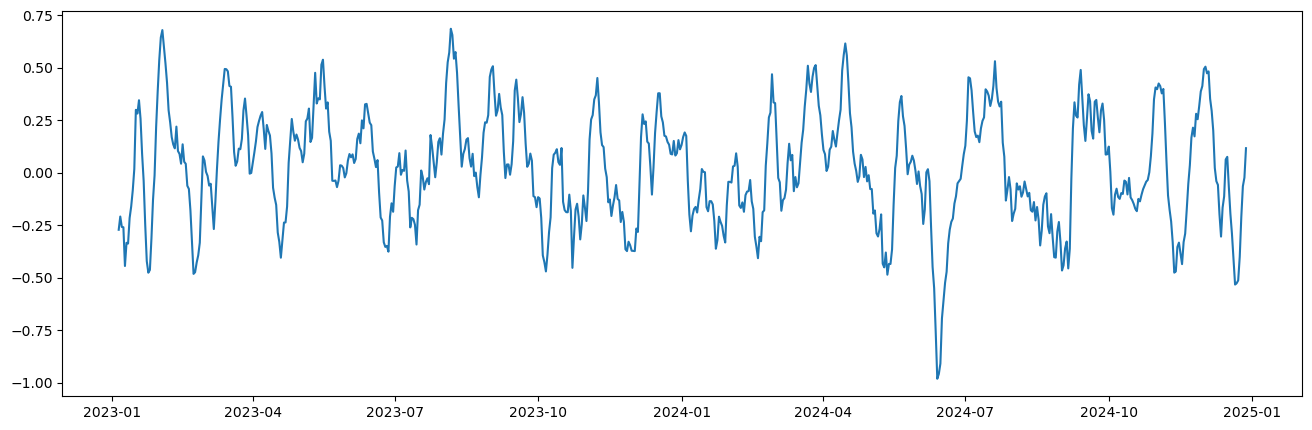

In [21]:
#see trends
plt.figure(figsize = [16,5])
plt.plot(decomposed_data.trend);

The dataset does not show a clear overall trend. However, there appears to be a potential outlier during the summer of 2024.

**•	The autocorrelation function**

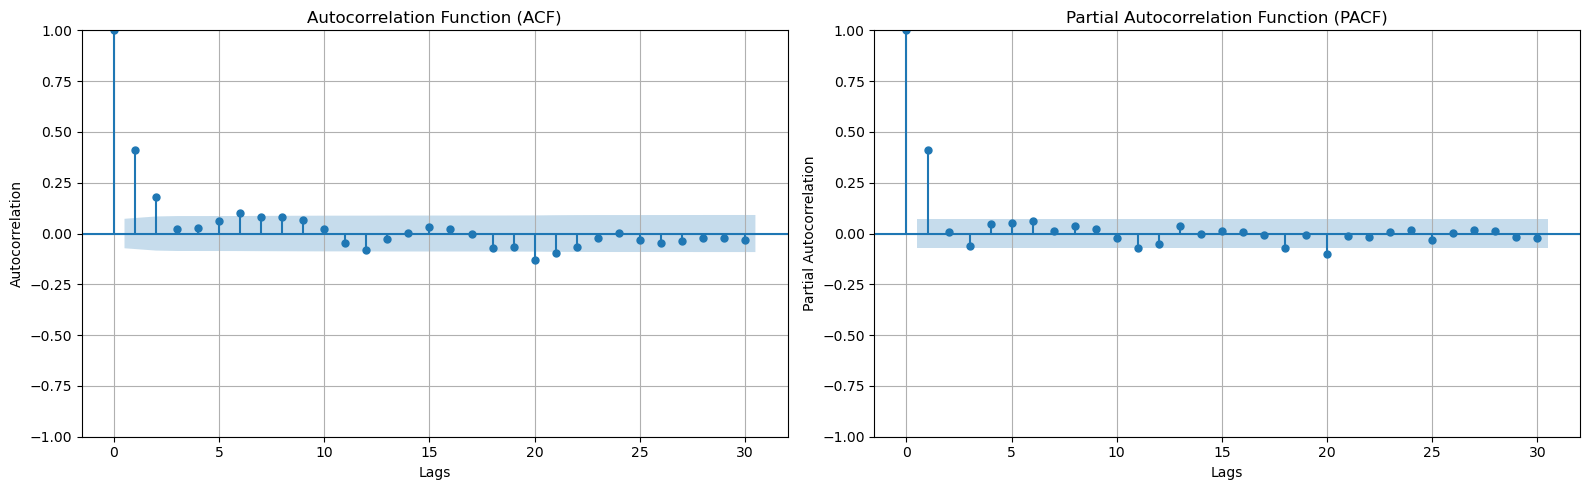

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

#calculate and plot the ACF
plot_acf(df_stat, lags=30, ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF)')
axes[0].set_xlabel('Lags')
axes[0].set_ylabel('Autocorrelation')
axes[0].grid(True)

#calculate and plot the PACF
plot_pacf(df_stat, lags=30, ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function (PACF)')
axes[1].set_xlabel('Lags')
axes[1].set_ylabel('Partial Autocorrelation')
axes[1].grid(True)

plt.tight_layout()
plt.show()


The ACF (Autocorrelation Function) and PACF (Partial Autocorrelation Function) plots help us understand if our data follows an AR (autoregressive) or MA (moving average) model. In these plots, the shaded area represents results that aren't statistically important so that we can ignore those points. The ACF plot shows a gradual decline up to lag 2, suggesting a moving average process, while the PACF plot has an explicit cutoff at lag 1, indicating an autoregressive process. 


**•	The spectral density**

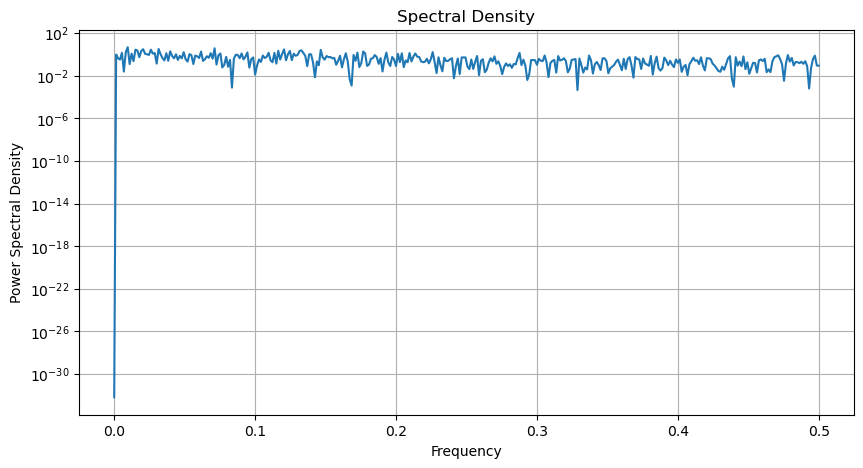

In [23]:
#calculate and plot the spectral density
freqs, psd = periodogram(df_stat)
plt.figure(figsize=(10, 5))
plt.semilogy(freqs, psd)
plt.title('Spectral Density')
plt.xlabel('Frequency')
plt.ylabel('Power Spectral Density')
plt.grid(True)
plt.show()

This analysis and previous observations indicate that monthly seasonality exists in the data.

**•	The decomposed time series** 

For creating time series code from Jayita Gulati was used (Gulati, 2024).

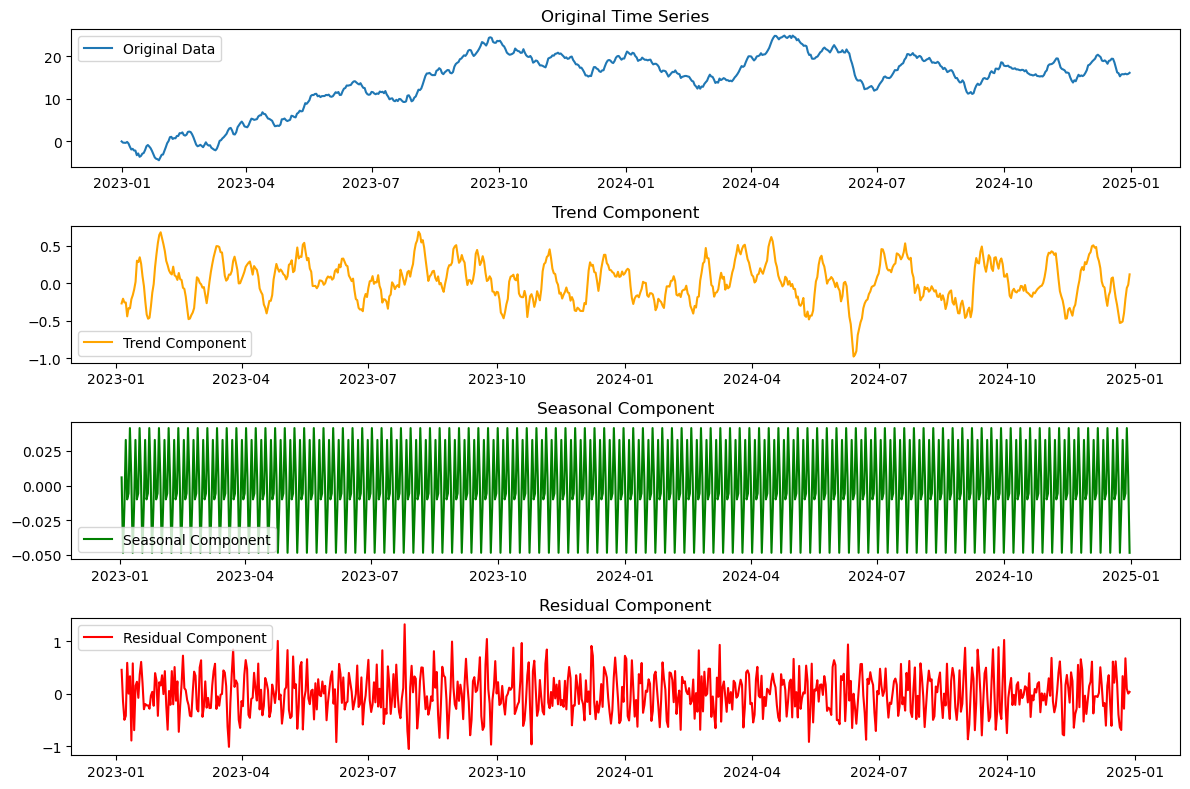

In [24]:
#plot the decomposed components
plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
plt.plot(df['Revenue'], label='Original Data')
plt.title('Original Time Series')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(decomposed_data.trend, label='Trend Component', color='orange')
plt.title('Trend Component')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(decomposed_data.seasonal, label='Seasonal Component', color='green')
plt.title('Seasonal Component')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(decomposed_data.resid, label='Residual Component', color='red')
plt.title('Residual Component')
plt.legend()

plt.tight_layout()
plt.show()

The time series decomposition breaks down the dataset into four components: the original time series, the trend component, the seasonal component, and the residual component. The original time series shows fluctuations over time with an upward trend and periodic fluctuations. The trend component captures the long-term progression of the data and fluctuates around zero, helping to highlight other patterns. The seasonal component reveals clear, repeating patterns, indicating strong seasonality within the data. Lastly, the residual component represents the remaining variability or noise after removing the trend and seasonal components, fluctuating around zero. 


**•	Confirmation of the lack of trends in the residuals of the decomposed series**

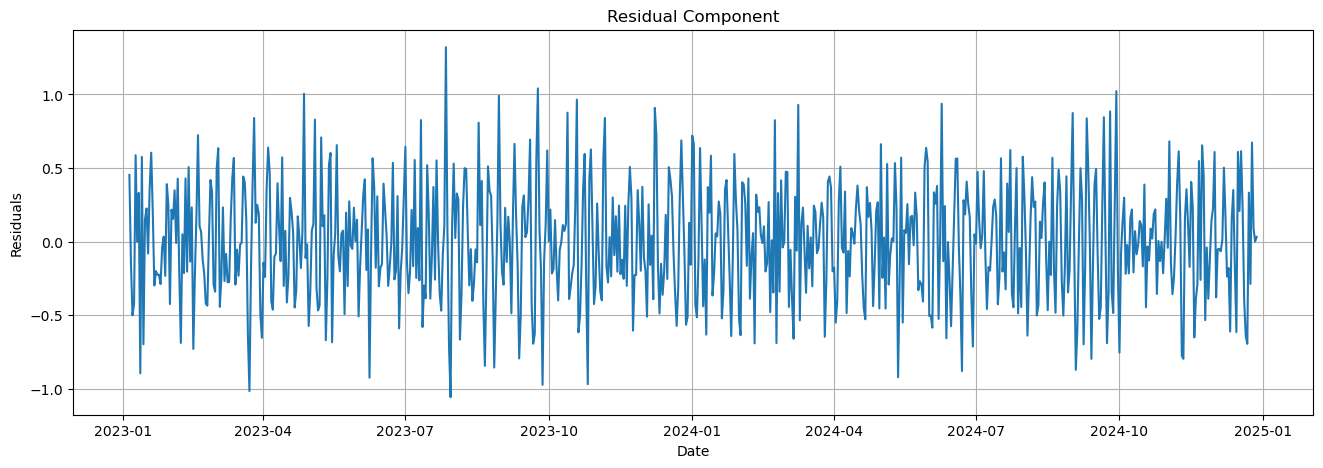

In [25]:
#confirmation of the lack of trends in the residuals of the decomposed series
plt.figure(figsize=[16, 5])
plt.plot(decomposed_data.resid)
plt.title('Residual Component')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()

The residual component plot shows the residuals from January 2023 to January 2025. The residuals fluctuate around zero with no obvious trend or pattern. This indicates that the residuals are stationary, and any trends or seasonality have been removed from the data. The range of the residuals is between approximately -1.0 and 1.0.

**D2:ARIMA MODEL**

In [26]:
pip install pmdarima

Note: you may need to restart the kernel to use updated packages.


Since Dr. Elleh, in his D213 Task 1 Panopto presentation videos, gave an example of a SARIMAX model, I decided to create my assessment using the stepwise_fit function with the auto_arima function and then fit the best parameters in a SARIMA model (Elleh, n.d.-b). 
Auto_arima and SARIMAX do not require the dataset to be stationary because they have built-in mechanisms to handle non-stationarity. Auto_arima automatically applies differencing to the data to remove trends and seasonality, transforming the non-stationary series into a stationary one. Similarly, SARIMAX can apply differencing and transformations to achieve stationarity while allowing seasonal and exogenous components to be included. This enables both functions to work directly with the original dataset and accurately capture the underlying patterns.

I used the auto_arima function in the code provided to build an ARIMA model with monthly seasonality, adapting code by geeksforgeeks (GeeksforGeeks, 2020). I chose p and q based on the ACF and PACF plots. Values in the range of 1 to 2 would be suitable starting points. Additionally, I set m = 30 to account for the monthly seasonality observed in the data, as there are approximately 30 days in a month. 


In [27]:
from pmdarima import auto_arima

#create start model using auto_arima with monthly seasonality
stepwise_fit = auto_arima(df['Revenue'], start_p=1, start_q=1, 
                          max_p=2, max_q=2, m=30,
                          start_P=0, 
                          seasonal=True, 
                          d=None, D=1, trace=True, 
                          error_action='ignore', 
                          suppress_warnings=True, 
                          stepwise=True)
print(stepwise_fit.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[30]             : AIC=inf, Time=6.81 sec
 ARIMA(0,1,0)(0,1,0)[30]             : AIC=1476.444, Time=0.15 sec
 ARIMA(1,1,0)(1,1,0)[30]             : AIC=1118.697, Time=1.46 sec
 ARIMA(0,1,1)(0,1,1)[30]             : AIC=inf, Time=7.70 sec
 ARIMA(1,1,0)(0,1,0)[30]             : AIC=1336.118, Time=0.77 sec
 ARIMA(1,1,0)(2,1,0)[30]             : AIC=1057.622, Time=3.70 sec
 ARIMA(1,1,0)(2,1,1)[30]             : AIC=inf, Time=30.15 sec
 ARIMA(1,1,0)(1,1,1)[30]             : AIC=inf, Time=7.01 sec
 ARIMA(0,1,0)(2,1,0)[30]             : AIC=1195.475, Time=1.83 sec
 ARIMA(2,1,0)(2,1,0)[30]             : AIC=1059.562, Time=5.29 sec
 ARIMA(1,1,1)(2,1,0)[30]             : AIC=1059.570, Time=6.86 sec
 ARIMA(0,1,1)(2,1,0)[30]             : AIC=1082.532, Time=4.74 sec
 ARIMA(2,1,1)(2,1,0)[30]             : AIC=1060.641, Time=13.22 sec
 ARIMA(1,1,0)(2,1,0)[30] intercept   : AIC=1059.621, Time=12.30 sec

Best model:  ARIMA(1,1,0)(2,1,0)[30

After utilizing the stepwise_fit function with auto_arima to identify the optimal model parameters for monthly seasonality, I moved on to fitting a SARIMAX model using these parameters on the training set. Specifically, I fitted a SARIMAX(1, 1, 0)x(2, 1, 0, 30) model to effectively capture both the autoregressive and moving average components, as well as the monthly seasonality.

In [28]:
#fit a SARIMAX(1, 1, 0)x(2, 1, 0, 30) on the training set 
modelTR = SARIMAX(train['Revenue'], 
                          order=(1, 1, 0), 
                          seasonal_order=(2, 1, 0, 30))

result = modelTR.fit()
print(result.summary())

                                     SARIMAX Results                                      
Dep. Variable:                            Revenue   No. Observations:                  584
Model:             SARIMAX(1, 1, 0)x(2, 1, 0, 30)   Log Likelihood                -415.216
Date:                            Thu, 13 Feb 2025   AIC                            838.432
Time:                                    01:34:09   BIC                            855.693
Sample:                                01-01-2023   HQIC                           845.175
                                     - 08-06-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4102      0.038     10.664      0.000       0.335       0.486
ar.S.L30      -0.6858      0.043   

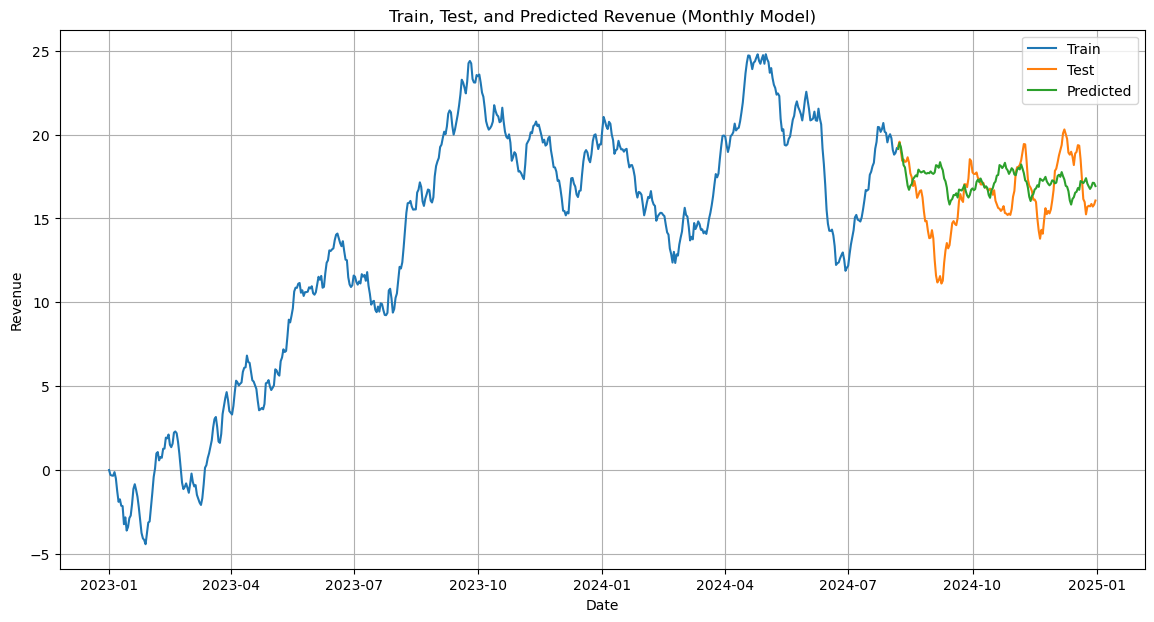

In [29]:
#make predictions on the test set
start = len(train)
end = len(train) + len(test) - 1
predictions = result.predict(start=start, end=end, typ='levels')
predictions.index = test.index

#plot the predictions and actual values for the monthly model
plt.figure(figsize=(14, 7))
plt.plot(train.index, train['Revenue'], label='Train')
plt.plot(test.index, test['Revenue'], label='Test')
plt.plot(predictions.index, predictions, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.title('Train, Test, and Predicted Revenue (Monthly Model)')
plt.legend()
plt.grid(True)
plt.show()

In [30]:
from math import sqrt

#calculate MSE and RMSE
mse = mean_squared_error(test["Revenue"], predictions)
rmse = sqrt(mse)

print('Model - MSE:', mse)
print('Model - RMSE:', rmse)

Model - MSE: 5.3260207769175025
Model - RMSE: 2.3078173187922615


In [31]:
mae = np.mean(np.abs(result.resid))
print('Mean absolute error', mae)

Mean absolute error 0.41262413535301395


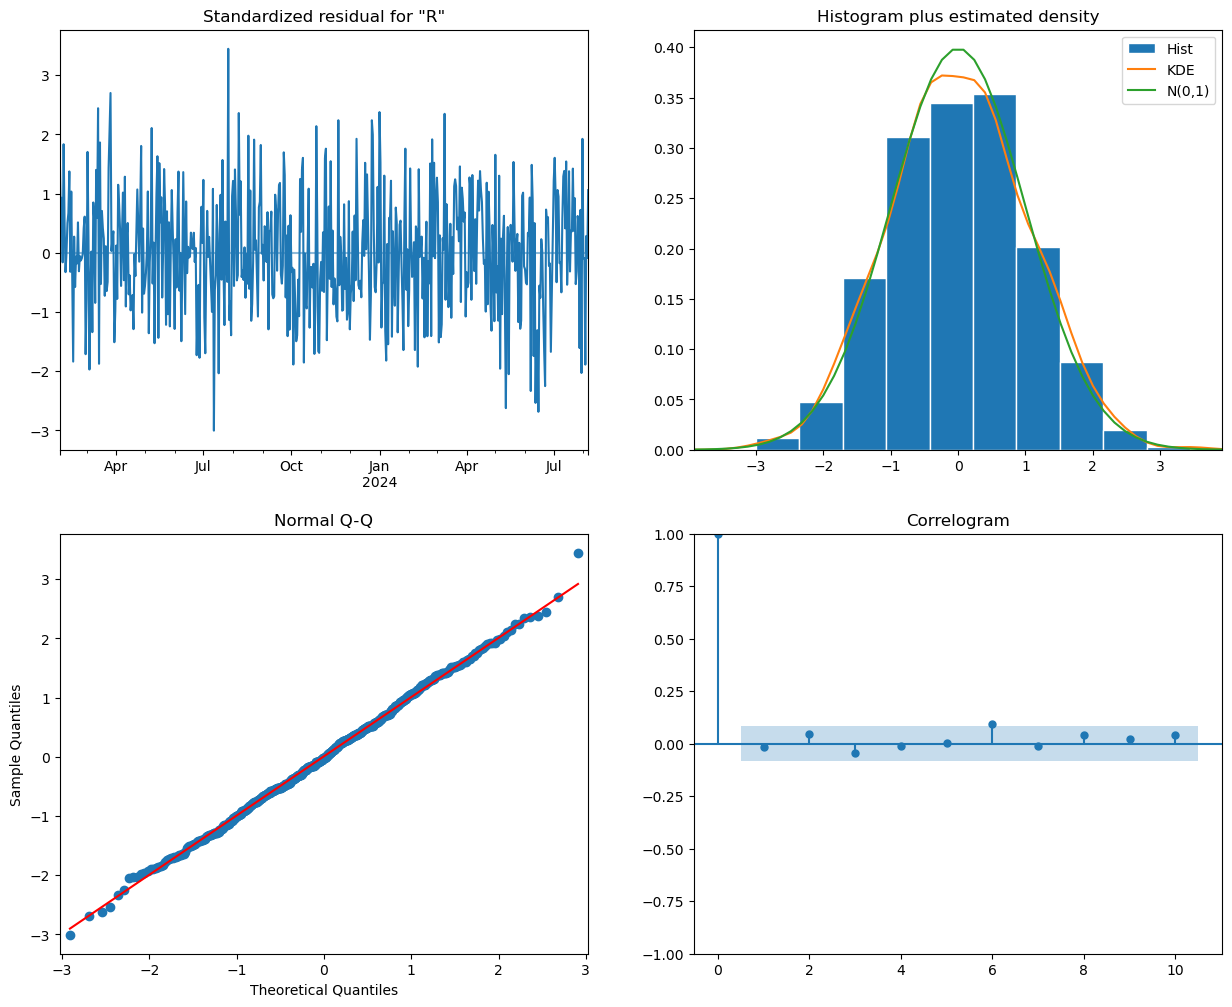

In [32]:
#generate the 4 diagnostic plots
result.plot_diagnostics(figsize=(15, 12))
plt.show()

**The Standardized Residuals** plot displays the standardized residuals over time, with the x-axis representing time from April 2023 to July 2024 and the y-axis representing the standardized residual values. The residuals fluctuate around zero without displaying any apparent trend or pattern. This behavior suggests that the residuals are randomly distributed, indicating that the model captures the underlying structure of the data well.

**Histogram Plus Estimated Density** plot shows a histogram of the residuals with an overlaid Kernel Density Estimate (KDE) and a normal distribution curve (N(0,1)). The histogram appears roughly bell-shaped, and the KDE and normal distribution curves closely match the histogram. This suggests that the residuals are approximately normally distributed, which is a desirable property for the residuals of a well-fitted model.

**Normal Q-Q** plot compares the quantiles of the residuals to the theoretical quantiles of a normal distribution. The points lie close to the red reference line, indicating that the residuals follow a normal distribution. This further supports the normality assumption of the residuals, which is essential for the validity of the model's inference.

**The Correlogram** shows the residuals' autocorrelation function (ACF) with lags from 0 to 10. The x-axis represents the lag, and the y-axis represents the autocorrelation. Most autocorrelation values fall within the blue confidence interval bands, suggesting no significant autocorrelation in the residuals. This indicates that the residuals are independent and unrelated, a key assumption for the model's validity.

The diagnostic plots indicate that the model's residuals are randomly distributed around zero, approximately normally distributed, and free from significant autocorrelation. These characteristics suggest that the model is well-fitted and its assumptions are reasonably met, providing confidence in its forecasts.

**D3:FORECASTING USING ARIMA MODEL**

In [33]:
#train the model on the full dataset for future forecasting
final_model = SARIMAX(df['Revenue'], 
                      order=(1, 1, 0), 
                      seasonal_order=(2, 1, 0, 30))

result_final = final_model.fit()
print(result_final.summary())

                                     SARIMAX Results                                      
Dep. Variable:                            Revenue   No. Observations:                  731
Model:             SARIMAX(1, 1, 0)x(2, 1, 0, 30)   Log Likelihood                -524.811
Date:                            Thu, 13 Feb 2025   AIC                           1057.622
Time:                                    01:34:15   BIC                           1075.826
Sample:                                01-01-2023   HQIC                          1064.659
                                     - 12-31-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4262      0.034     12.584      0.000       0.360       0.493
ar.S.L30      -0.6889      0.037   

In [34]:
#forecast for the next 90 days
forecast_periods = 90
forecast_object = result_final.get_forecast(steps=forecast_periods)
forecast = forecast_object.predicted_mean
confidence_intervals = forecast_object.conf_int()

#create a DataFrame with forecast and confidence intervals
forecast_values = pd.DataFrame({
    'Date': forecast.index,
    'Forecasted Revenue': forecast.values,
    'Lower Bound': confidence_intervals.iloc[:, 0],
    'Upper Bound': confidence_intervals.iloc[:, 1]
})

print(forecast_values)

                 Date  Forecasted Revenue  Lower Bound  Upper Bound
2025-01-01 2025-01-01           16.442152    15.449758    17.434546
2025-01-02 2025-01-02           16.665549    14.936940    18.394157
2025-01-03 2025-01-03           16.689163    14.336691    19.041636
2025-01-04 2025-01-04           16.808033    13.921641    19.694426
2025-01-05 2025-01-05           16.900429    13.547967    20.252891
...               ...                 ...          ...          ...
2025-03-27 2025-03-27           13.009962    -9.004193    35.024117
2025-03-28 2025-03-28           13.148139    -9.083198    35.379475
2025-03-29 2025-03-29           13.254799    -9.191618    35.701217
2025-03-30 2025-03-30           13.604503    -9.054954    36.263959
2025-03-31 2025-03-31           14.116959    -8.753553    36.987471

[90 rows x 4 columns]


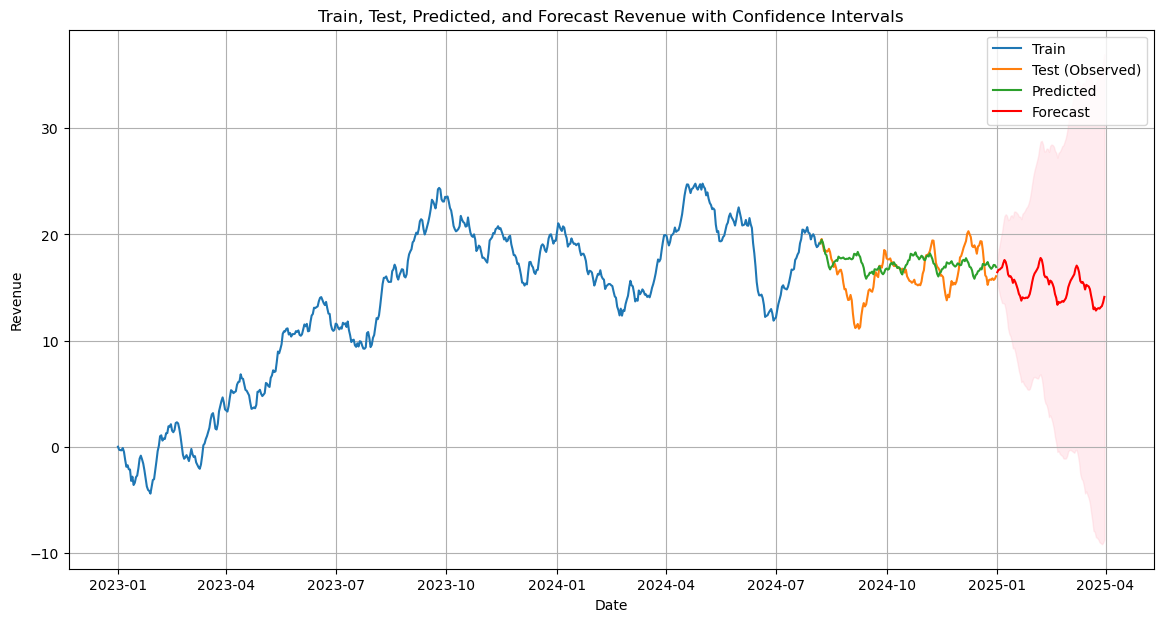

In [35]:
#plot the train, test, predictions, and forecast with confidence intervals
plt.figure(figsize=(14, 7))
plt.plot(train.index, train['Revenue'], label='Train')
plt.plot(test.index, test['Revenue'], label='Test (Observed)')
plt.plot(predictions.index, predictions, label='Predicted')
plt.plot(forecast.index, forecast, label='Forecast', color='r')
plt.fill_between(confidence_intervals.index,
                 confidence_intervals.iloc[:, 0],
                 confidence_intervals.iloc[:, 1], color='pink', alpha=0.3)
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.title('Train, Test, Predicted, and Forecast Revenue with Confidence Intervals')
plt.legend()
plt.grid(True)
plt.show()

**D4:OUTPUT AND CALCULATIONS**

All of the calculations that I've performed, and their resulting outputs, can be seen above

**D5:CODE**

The code used for data preparation and model building is shown above.


**E1:RESULTS**

**Selection of an ARIMA Model**

To accurately predict the revenue for the WGU Hospital System, I employed the auto_arima function to identify the best-fitting ARIMA model. This function automatically selects the optimal model by evaluating various combinations of parameters with monthly seasonality (m=30). The chosen model, ARIMA(1,1,0)(2,1,0)[30], indicates one non-seasonal autoregressive term, first-order differencing, no non-seasonal moving average terms, two seasonal autoregressive terms, first-order seasonal differencing, and no seasonal moving average terms. For example, by specifying parameters like start_p=1, start_q=1, max_p=2, and max_q=2, the auto_arima function systematically explored different models, ultimately selecting the one that best balances model complexity and forecasting accuracy. The selection process ensures the model's suitability for the data, facilitating reliable revenue predictions.


**Prediction Interval of the Forecast**

To generate the forecast for the next 90 days, I used the final SARIMAX model trained on the entire dataset (df['Revenue']). Prediction or confidence intervals were calculated to provide a range within which future revenue values are expected to lie with a certain confidence level. For instance, on January 1, 2025, the forecasted revenue is 16.44, with a lower bound of 15.45 and an upper bound of 17.43. This means we expect the actual revenue on this date to fall within this range with a specified confidence level. Similarly, the forecast for March 31, 2025, is 14.12, with a lower bound of -8.75 and an upper bound of 36.99. These intervals are crucial as they account for the forecast uncertainty, offering a more nuanced understanding of the expected revenue. The DataFrame presenting these results showcases the forecasted revenue values alongside their respective lower and upper bounds, thus providing a clear and detailed view of the expected future trends.


**Justification of the Forecast Length**

A 90-day forecast period was selected to align with the quarterly planning cycles of the WGU Hospital System. This period is appropriate because it captures short-term trends and seasonal effects relevant to the hospital's operations. For example, hospitals often plan their resources, staffing, and budget every quarter, making a 90-day forecast highly valuable for strategic decision-making. By forecasting revenue for the next three months, the hospital can better anticipate demand, allocate resources efficiently, and make informed financial decisions. The chosen forecast length ensures that the predictions are timely and actionable, providing a solid foundation for effective planning and management.



**Model Evaluation Procedure and Error Metric**

The model's performance was evaluated using a train-test split approach, where the SARIMAX(1,1,0)x(2,1,0,30) model was fitted on the training set, and predictions were made on the test set. The evaluation metrics used to assess the model's accuracy included Mean Squared Error (MSE), Root Mean Squared Error (RMSE), and Mean Absolute Error (MAE). For instance, the model achieved an MSE of 5.33, an RMSE of 2.31, and an MAE of 0.41. These metrics indicate the average squared difference between the predicted and actual revenue values, the square root of that average, and the average absolute difference between the predicted and actual values, respectively. An MAE lower than 0.5 is considered good, further validating the model's accuracy. Additionally, diagnostic plots were generated to check the model's assumptions and residuals, ensuring that the model fit the data well. This thorough evaluation confirms the model's reliability and ability to make accurate revenue predictions for the WGU Hospital System.




**E2:ANNOTATED VISUALIZATION**

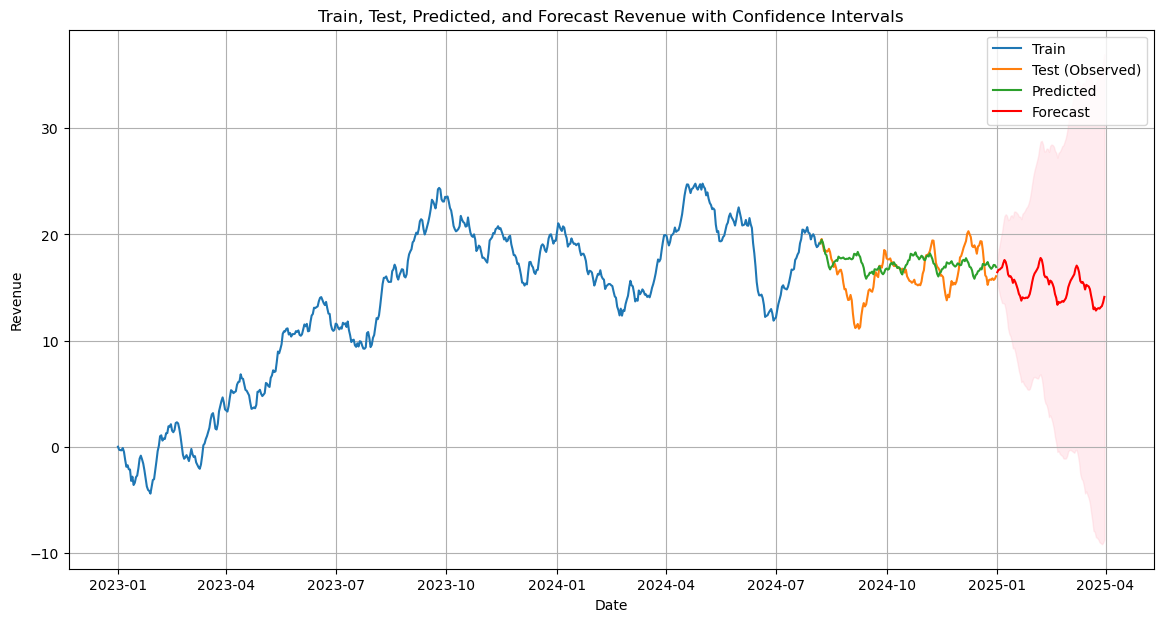

In [36]:
#plot the train, test, predictions, and forecast with confidence intervals
plt.figure(figsize=(14, 7))
plt.plot(train.index, train['Revenue'], label='Train')
plt.plot(test.index, test['Revenue'], label='Test (Observed)')
plt.plot(predictions.index, predictions, label='Predicted')
plt.plot(forecast.index, forecast, label='Forecast', color='r')
plt.fill_between(confidence_intervals.index,
                 confidence_intervals.iloc[:, 0],
                 confidence_intervals.iloc[:, 1], color='pink', alpha=0.3)
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.title('Train, Test, Predicted, and Forecast Revenue with Confidence Intervals')
plt.legend()
plt.grid(True)
plt.show()

The graph "Train, Test, Predicted, and Forecast Revenue with Confidence Intervals" offers a comprehensive view of revenue trends over time. The blue line represents the training data, showing consistent trends and seasonal variations. The orange line indicates the observed test data, closely aligning with the green line of predicted values, validating the model's accuracy. Based on historical data, the red line forecasts revenue for the next 90 days, from January 2025 to April 2025. The shaded area around the red line represents the confidence intervals, showing the range within which the actual revenue values are expected to fall with a specified confidence level. The intervals widen towards the end, reflecting increased uncertainty. Overall, the graph effectively captures historical trends, accurately predicts test data, and forecasts future revenue, providing valuable insights for decision-making and strategic planning for the WGU Hospital System.

**E3:RECOMMENDATION**

Based on the results of the data analysis and the accurate revenue predictions generated by the ARIMA model for the WGU Hospital System, I recommend a multifaceted course of action. Firstly, leverage the 90-day revenue forecast to inform strategic planning for the upcoming quarter, including budgeting, resource allocation, and staffing decisions. Adjust operational plans to optimize revenue streams by increasing staff or resources during high-revenue periods and implementing cost-saving measures during low-revenue periods. Utilize the prediction intervals to assess potential risks and develop contingency plans for scenarios where actual revenue falls within the lower bounds of the intervals. Regularly update the model with new revenue data to maintain its accuracy and reliability, and extend the dataset to capture more seasonal variations and trends. While the current model is effective, it is based on two years of data. To enhance the model's accuracy and robustness, collecting and incorporating revenue data from a longer period is recommended. A more extended dataset will capture seasonal variations and trends, leading to more reliable forecasts. Additionally, communicate the forecasted revenue data and insights with key stakeholders, ensuring transparency and facilitating informed discussions about future strategies. By following these recommendations and incorporating extended data collection, the WGU Hospital System can enhance operational efficiency, manage risks, and strategically plan for the future.

**F:REPORTING**

I complete the tasks outlined in Part E within a development environment, such as Jupyter Notebook. The assignment is provided as both a Jupyter Notebook (.ipynb) file and an HTML document of the same content.


**G:SOURCES FOR THIRD-PARTY CODE**

Elleh, F. (n.d.-a). Advansed Data Analytics -Task 1. westerngovernorsuniversity.com. Retrieved February 4, 2025, from https://westerngovernorsuniversity.sharepoint.com/:p:/r/sites/DataScienceTeam/_layouts/15/Doc.aspx?sourcedoc=%7BDC38E039-2BB1-4EBE-B156-F79C16334FC6%7D&file=D213%20Task%201%20Cohort%20Webinar%20PPT.pptx&action=edit&mobileredirect=true 


GeeksforGeeks. (2020, February 19). Python | ARIMA model for Time Series Forecasting. GeeksforGeeks. https://www.geeksforgeeks.org/python-arima-model-for-time-series-forecasting/ 


Gulati, J. (2024, August 19). How to Decompose Time Series Data into Trend, Seasonal, and Residual Components in Python. Statology. https://www.statology.org/how-to-decompose-time-series-data-into-trend-seasonal-and-residual-components-in-python/?form=MG0AV3

**H:SOURCES**

Elleh, F. (n.d.-b). D213 Task 1 Building Arima Model in Python video [Video]. https://wgu.hosted.panopto.com/. Retrieved February 5, 2025, from https://wgu.hosted.panopto.com/Panopto/Pages/Viewer.aspx?id=1aaf2389-6483-4000-b498-b14f00441d57